In [1]:
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Seq import MutableSeq
from scipy import stats
import matplotlib.gridspec as gridspec
from collections import Counter
import requests
import math


Bad key "text.kerning_factor" on line 4 in
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
#Function to find path from root to clade
def get_parent(tree, child_clade):
    node_path = tree.get_path(child_clade)
    return node_path

In [11]:
def tally_tips_with_mut(date, gene, mutation):
    
    #Download tree json
    tree_url = f"https://data.nextstrain.org/ncov_global_{date}.json"

    tree_json = requests.get(tree_url).json()

    #Put tree in Bio.Phylo format
    tree = json_to_tree(tree_json)
    
    mutation_position = int(mutation[1:-1])
    
    total_tips = 0
    tips_with_mutation = 0
    
    for node in tree.find_clades(terminal=True):
        total_tips+=1
        muts_at_position = []
        
        parents = get_parent(tree, node)
        for p in parents:
            if hasattr(p, 'branch_attrs'):
                if gene in p.branch_attrs["mutations"]:
                    mut_list = p.branch_attrs["mutations"][gene]
                    for mut in mut_list:
                        if int(mut[1:-1]) == mutation_position:
                            muts_at_position.append(mut)
                            
        if len(muts_at_position)>0:                    
            final_mutation_at_pos = muts_at_position[-1]
            final_genotype_at_pos = final_mutation_at_pos[-1]
            if final_genotype_at_pos == mutation[-1]:
                tips_with_mutation+=1
                
    mutation_frequency = tips_with_mutation/total_tips
                
    return mutation_frequency
                            
    
                            

In [19]:
def find_mutation_frequency_over_time(dates, gene, mutation):
    
    frequency_over_time = {}
    
    for date in dates:
        mutation_frequency = tally_tips_with_mut(date, gene, mutation)
        frequency_over_time[date] = mutation_frequency
    
    return frequency_over_time
    
    
    

In [16]:
def compare_mutations_over_time(dates, full_mutations):
    
    all_freqs_over_time = []
    
    for m in full_mutations:
        gene = m.split('_')[0]
        mutation = m.split('_')[1]
        
        frequency_over_time = find_mutation_frequency_over_time(dates, gene, mutation)
        for k,v in frequency_over_time.items():
            all_freqs_over_time.append({'mutation': m, 'date': k, 'freq': v})
            
    all_freqs_df = pd.DataFrame(all_freqs_over_time)
    
    return all_freqs_df

In [23]:
def plot_freqs(dates, full_mutations):
    
    all_freqs_df = compare_mutations_over_time(dates, full_mutations)
    
    fig, ax = plt.subplots(figsize=(10,5))
    
    ax = sns.lineplot(x='date', y='freq', hue= 'mutation', data = all_freqs_df, ax=ax)
    
    sns.despine(left=False, bottom=False)
    ax.set_ylabel('frequency', fontsize=16)
    ax.set_xlabel('')
    
    

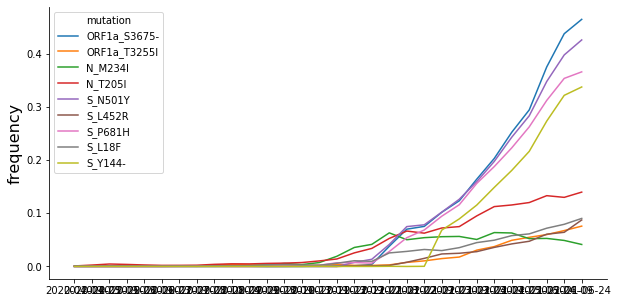

In [27]:
plot_freqs(['2020-04-09', '2020-04-23', '2020-05-09', '2020-05-23', 
            '2020-06-09', '2020-06-23', '2020-07-09', '2020-07-23', 
            '2020-08-10', '2020-08-24', '2020-09-09', '2020-09-23', 
            '2020-10-09', '2020-10-23', '2020-11-09', '2020-11-23', 
            '2020-12-09', '2020-12-22', '2021-01-08', '2021-01-22', 
            '2021-02-09', '2021-02-23', '2021-03-09', '2021-03-23', 
            '2021-04-09', '2021-04-23', '2021-05-06', '2021-05-24', 
            '2021-06-09', '2021-06-24'], 
           ['ORF1a_S3675-', 'ORF1a_T3255I', 'N_M234I', 
            'N_T205I', 'S_N501Y', 'S_L452R', 
            'S_P681H', 'S_L18F', 'S_Y144-'])

In [20]:
compare_mutations_over_time(['2021-05-24', '2021-06-04', '2021-06-10', 
                 '2021-06-17', '2021-06-24'], ['ORF1a_S3675-', 'S_N501Y', 'S_L452R'])

,mutation,date,freq
0,ORF1a_S3675-,2021-05-24,0.374840
1,ORF1a_S3675-,2021-06-04,0.390840
2,ORF1a_S3675-,2021-06-10,0.424279
3,ORF1a_S3675-,2021-06-17,0.459094
4,ORF1a_S3675-,2021-06-24,0.464229
5,S_N501Y,2021-05-24,0.347481
6,S_N501Y,2021-06-04,0.351808
7,S_N501Y,2021-06-10,0.387885
8,S_N501Y,2021-06-17,0.415061
9,S_N501Y,2021-06-24,0.425565


In [10]:
tally_tips_with_mut('S', 'L452R')

0.11732851985559567